In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
from scripts.going_modular import data_setup, engine
from scripts.helper_functions import set_seeds

c:\Users\Andakara\.conda\envs\.metlit-venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Prep

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
set_seeds()

In [5]:
#Prepare dataset for training
image_path = '../data/CombinedAll'
dest_dir = '../data/CombinedAll'
categories = ['Healthy', 'Patient']

# Create destination directories
for category in categories:
    os.makedirs(os.path.join(dest_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'test', category), exist_ok=True)

# Split and copy files
for category in categories:
    category_path = os.path.join(image_path, category)
    files = os.listdir(category_path)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(dest_dir, 'train', category, file))
    
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(dest_dir, 'test', category, file))

print("Dataset split into training and test sets successfully.")

Dataset split into training and test sets successfully.


In [6]:
from pathlib import Path

In [7]:
# Setup path to data folder
data_path = Path("../data/")
image_path = data_path / "CombinedAll"

In [8]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('../data/CombinedAll/train'),
 WindowsPath('../data/CombinedAll/test'))

# ViT Model Prep

In [9]:
# 1. Get pretrained weights for ViT-Base
vitb16_0_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
vitb16_0 = torchvision.models.vit_b_16(weights=vitb16_0_weights).to(device)

# 3. Freeze the base parameters
for parameter in vitb16_0.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
vitb16_0.heads = nn.Linear(in_features=768, out_features=1).to(device)
vitb16_0 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [10]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vitb16_0,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [11]:
# Get automatic transforms from pretrained ViT weights
vitb16_0_transforms = vitb16_0_weights.transforms()
print(vitb16_0_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [12]:
# Setup dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vitb16_0_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x24917819700>,
 ['Healthy', 'Patient'])

In [63]:
class_names = ['sehat', 'parkinson']
class_names

['sehat', 'parkinson']

# Model Training

In [14]:
from scripts.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=vitb16_0.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
vitb16_0_results, vitb16_0_all_preds, vitb16_0_all_targets = engine.train(model=vitb16_0,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [00:30<04:34, 30.53s/it]

Epoch: 1 | train_loss: 0.4973 | train_acc: 0.7511 | test_loss: 0.4036 | test_acc: 0.8077


 20%|██        | 2/10 [00:57<03:49, 28.71s/it]

Epoch: 2 | train_loss: 0.3987 | train_acc: 0.8097 | test_loss: 0.3618 | test_acc: 0.8159


 30%|███       | 3/10 [01:25<03:16, 28.03s/it]

Epoch: 3 | train_loss: 0.3695 | train_acc: 0.8225 | test_loss: 0.3403 | test_acc: 0.8280


 40%|████      | 4/10 [01:52<02:46, 27.70s/it]

Epoch: 4 | train_loss: 0.3549 | train_acc: 0.8339 | test_loss: 0.3323 | test_acc: 0.8688


 50%|█████     | 5/10 [02:19<02:18, 27.66s/it]

Epoch: 5 | train_loss: 0.3423 | train_acc: 0.8547 | test_loss: 0.3202 | test_acc: 0.8640


 60%|██████    | 6/10 [02:48<01:51, 27.79s/it]

Epoch: 6 | train_loss: 0.3261 | train_acc: 0.8608 | test_loss: 0.3008 | test_acc: 0.8688


 70%|███████   | 7/10 [03:15<01:23, 27.70s/it]

Epoch: 7 | train_loss: 0.3134 | train_acc: 0.8580 | test_loss: 0.2930 | test_acc: 0.8688


 80%|████████  | 8/10 [03:43<00:55, 27.67s/it]

Epoch: 8 | train_loss: 0.3085 | train_acc: 0.8674 | test_loss: 0.2919 | test_acc: 0.8760


 90%|█████████ | 9/10 [04:11<00:27, 27.76s/it]

Epoch: 9 | train_loss: 0.3083 | train_acc: 0.8718 | test_loss: 0.2819 | test_acc: 0.8760


100%|██████████| 10/10 [04:40<00:00, 28.05s/it]

Epoch: 10 | train_loss: 0.2928 | train_acc: 0.8845 | test_loss: 0.2762 | test_acc: 0.8784


In [15]:
vitb16_0_results

{'train_loss': [0.49726079539819196,
  0.3987333792628664,
  0.3695469467025815,
  0.35487067563967273,
  0.3423140532139576,
  0.3260920675414981,
  0.31337422290534683,
  0.3085250055248087,
  0.3082954330426274,
  0.29277489560120035],
 'train_acc': [0.7511363636363637,
  0.8096590909090909,
  0.8225378787878788,
  0.8339015151515152,
  0.8547348484848485,
  0.8607954545454546,
  0.8579545454545454,
  0.8674242424242424,
  0.8717803030303031,
  0.884469696969697],
 'test_loss': [0.4035596073820041,
  0.3618405839571586,
  0.3402650860639719,
  0.33234002326543516,
  0.3201921805739403,
  0.30082854342002135,
  0.2929663337194003,
  0.2919238582253456,
  0.28190670305719745,
  0.27617500951656926],
 'test_acc': [0.8076923076923077,
  0.8159340659340659,
  0.8279532967032968,
  0.8688186813186813,
  0.864010989010989,
  0.8688186813186813,
  0.8688186813186813,
  0.8760302197802198,
  0.8760302197802198,
  0.8784340659340659]}

# Model Results Visualization

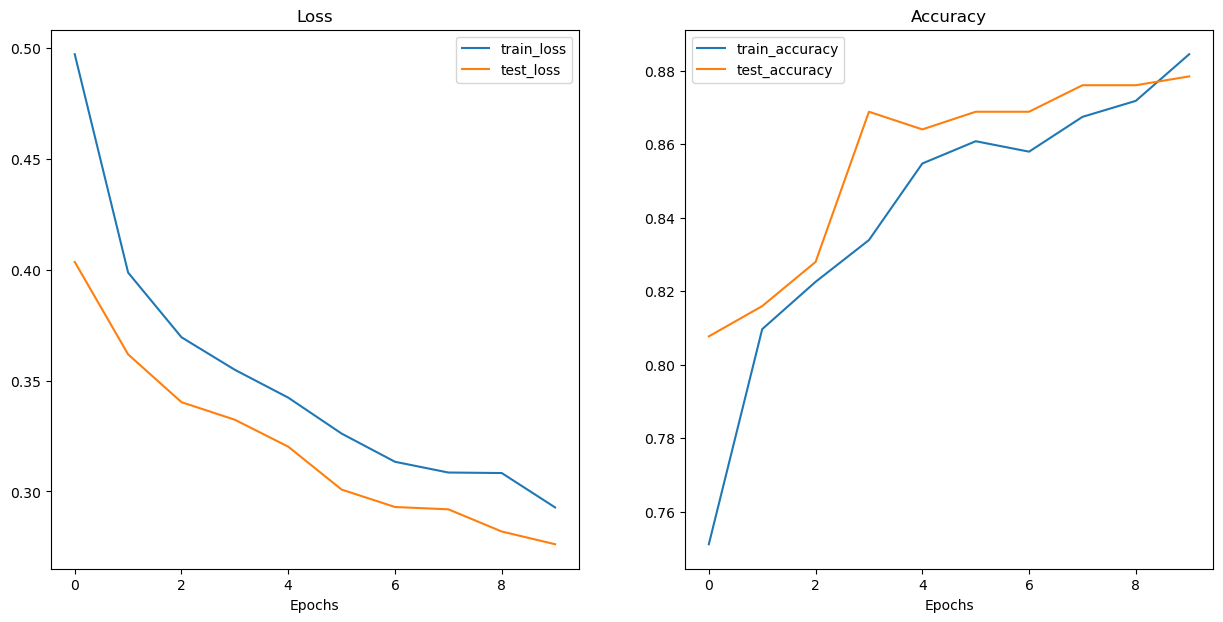

In [16]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(vitb16_0_results)

In [45]:
import importlib
import scripts.helper_functions
scripts.helper_functions = importlib.reload(scripts.helper_functions)
from scripts.helper_functions import pred_and_plot_image

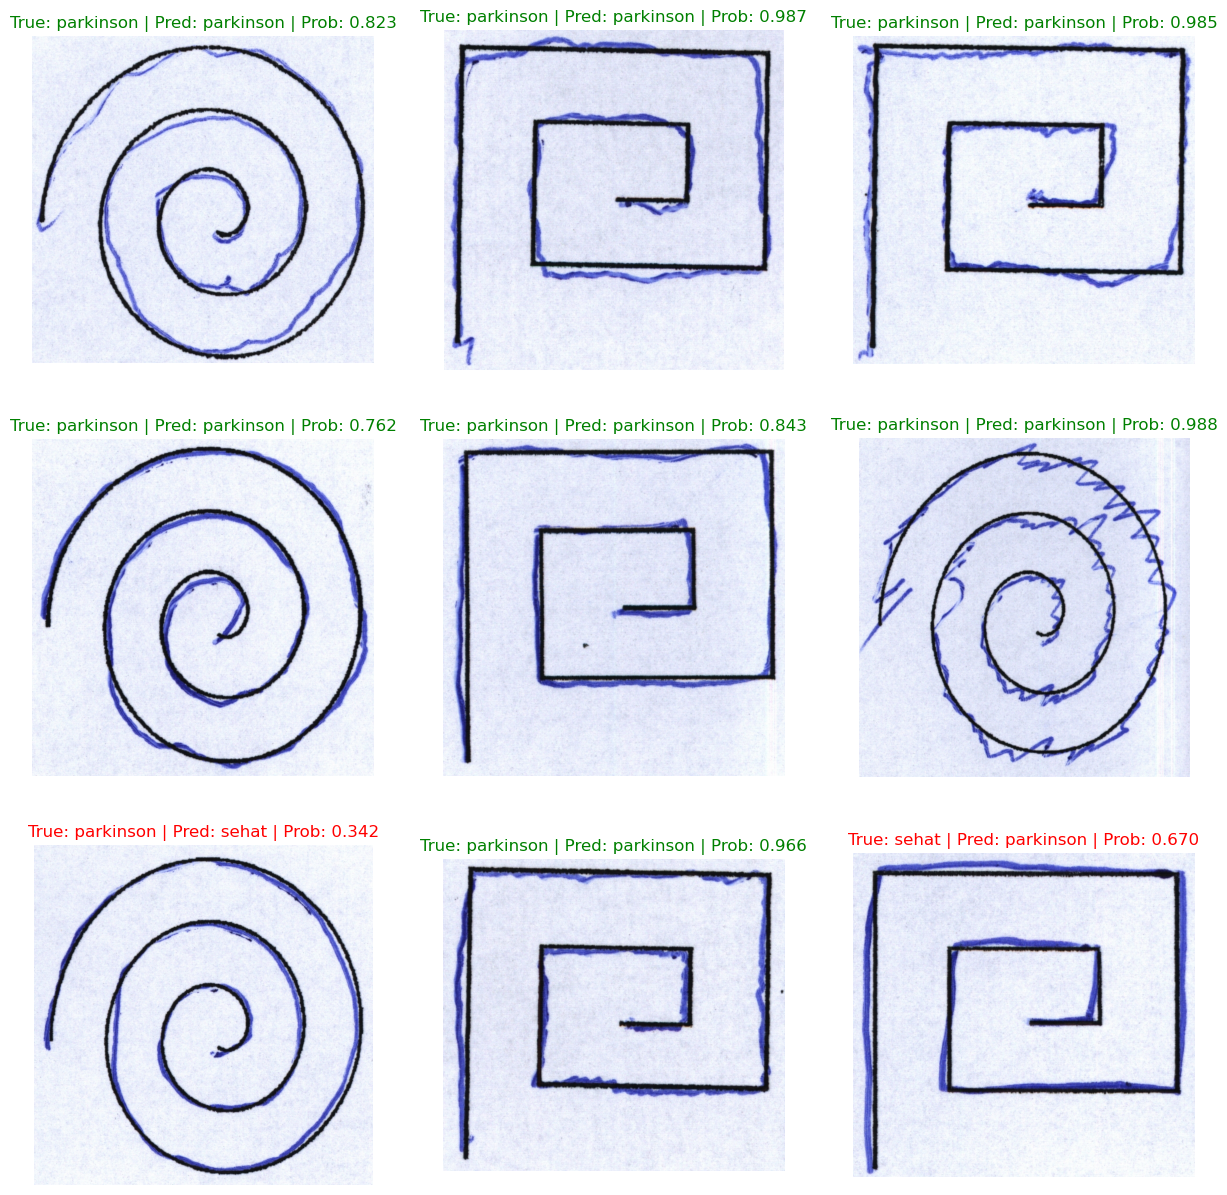

In [42]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 9
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images in a 3x3 grid
plt.figure(figsize=(15, 15))
for i, image_path in enumerate(test_image_path_sample):
    plt.subplot(3, 3, i + 1) 
    if image_path.parent.name == 'Healthy':
        true_class = 'sehat'
    else:
        true_class = 'parkinson'
    pred_and_plot_image(model=vitb16_0, 
                        image_path=image_path,
                        class_names=class_names,
                        true_class=true_class,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))
plt.show()

In [44]:
# Save the model
from scripts.going_modular import utils

utils.save_model(model=vitb16_0,
                 target_dir="../models",
                 model_name="vitb16_0.pth")

[INFO] Saving model to: ..\models\vitb16_0.pth


In [47]:
# Load the model
model_path = "../models/vitb16_0.pth"
model = torchvision.models.vit_b_16(weights=None)
model.heads = nn.Linear(in_features=768, out_features=1)
model.load_state_dict(torch.load(model_path))
model.eval()

# Define the transform (use the same transform as during training)
transform = vitb16_0_weights.transforms()

C:\Users\Andakara\AppData\Local\Temp\ipykernel_25772\703968383.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


# Test Model on Custom Dataset

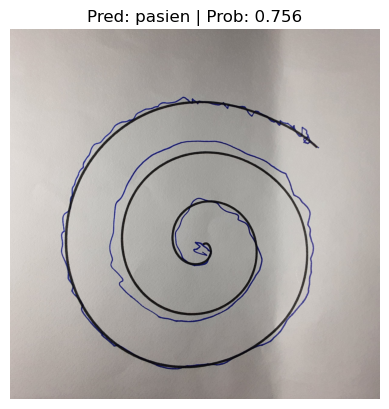

In [54]:
image_path = "../data/custom-patient.jpg"
class_names = ["sehat", "pasien"]
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, transform=transform, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

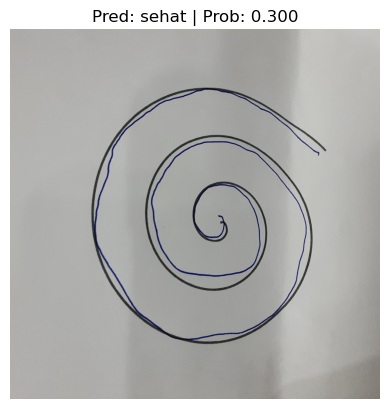

In [52]:
image_path = "../data/custom-healthy.jpg"
class_names = ["sehat", "pasien"]
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, transform=transform, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Confusion Matrix

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [56]:
from tqdm.auto import tqdm

In [57]:
test_preds = []
model.to(device)  # Move the model to the GPU
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.sigmoid(test_logits)

    # Convert the pred probs into pred labels (threshold at 0.5)
    pred_labels = (pred_probs > 0.5).int()

    # Add the pred labels to test preds list
    test_preds.append(pred_labels.cpu())

100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


In [58]:
# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu().squeeze()
test_preds

tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [59]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

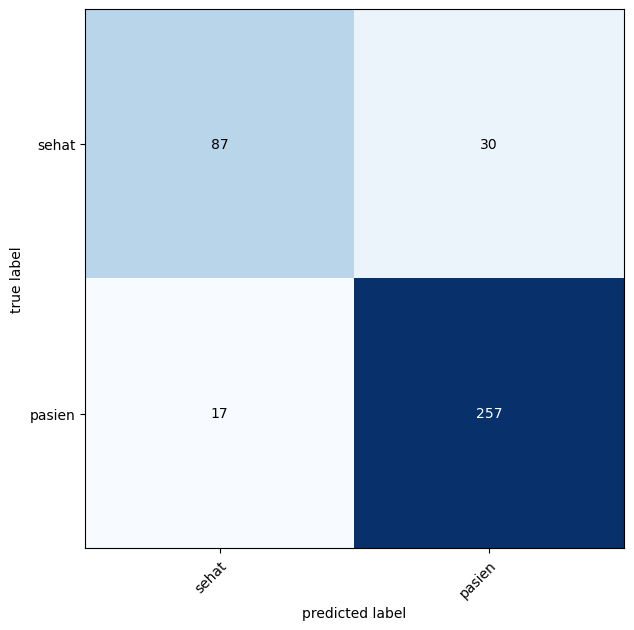

In [60]:
# Setup confusion matrix instance
confmat = ConfusionMatrix(task='binary', num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds, target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

# Save Model

In [62]:
# Save the model
from scripts.going_modular import utils

utils.save_model(model=vitb16_0,
                 target_dir="../models",
                 model_name="vitb16_0.pth")

[INFO] Saving model to: ..\models\vitb16_0.pth


In [64]:
# Load the model
model_path = "../models/vitb16_0.pth"
model = torchvision.models.vit_b_16(weights=None)
model.heads = nn.Linear(in_features=768, out_features=1)
model.load_state_dict(torch.load(model_path))
model.eval()

C:\Users\Andakara\AppData\Local\Temp\ipykernel_25772\3699427183.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [65]:
# Define the transform (use the same transform as during training)
transform = vitb16_0_weights.transforms()

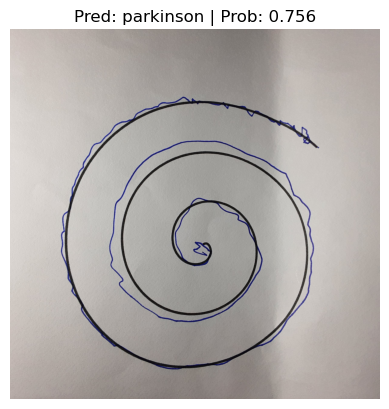

In [66]:
# Example usage
image_path = "../data/custom-patient.jpg"
class_names = ["sehat", "parkinson"]
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, transform=transform, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))